In [1]:
# General imports
import os
import sys
import numpy as np
import tensorflow as tf
import gc
import optuna

# Sklearn imports
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Keras imports
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Import library with current code functions
sys.path.append(os.path.join("..", "lib"))
import neural_network_functions as neural_net_fun
import general_functions as gf

2024-11-23 19:13:31.154918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/orlandomota/miniconda3/envs/tensor-gpu-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if TensorFlow can find the GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print("TensorFlow found the following GPU(s):")
    for device in physical_devices:
        print(device)
else:
    print("No GPU found. TensorFlow is running on the CPU.")

TensorFlow found the following GPU(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-11-23 19:13:32.757706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-23 19:13:32.847972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-23 19:13:32.848204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def objective(trial, timesteps, num_classes, num_features, X_balanced_normalized, Y_balanced, batch_size):
    conv_filters = trial.suggest_int('conv_filters', 16, 64)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    lstm_units = trial.suggest_int('lstm_units', 20, 150)
    dropout_conv = trial.suggest_float('dropout_conv', 0.2, 0.5)
    dropout_lstm = trial.suggest_float('dropout_lstm', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-8, 5)
    kernel_regularizer_l1 = trial.suggest_loguniform('kernel_regularizer_l1', 1e-6, 1e-2)
    kernel_regularizer_l2 = trial.suggest_loguniform('kernel_regularizer_l2', 1e-10, 1e-3)

    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Store scores
    scores = []

    for train_index, val_index in kf.split(X_balanced_normalized):
        X_train_fold, X_val = X_balanced_normalized[train_index], X_balanced_normalized[val_index]
        y_train_fold, Y_val = Y_balanced[train_index], Y_balanced[val_index]

        # Create the model
        model = neural_net_fun.define_model(
            timesteps, 
            num_features, 
            num_classes, 
            conv_filters, 
            kernel_size, 
            lstm_units, 
            dropout_conv, 
            dropout_lstm, 
            learning_rate, 
            kernel_regularizer_l1,
            kernel_regularizer_l2
        )
        
        # Early stopping and learning rate reduction callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=int(10/2), min_lr=1e-6)

        # Convert Y_train and Y_val to one-hot encoding
        y_train_fold = to_categorical(y_train_fold, num_classes)
        Y_val = to_categorical(Y_val, num_classes)

        # Train the model
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=batch_size, verbose=0, validation_data=(X_val, Y_val), callbacks=[early_stopping, lr_scheduler])
        
        # Evaluate the model
        y_pred = model.predict(X_val)
        y_pred = np.round(y_pred)
        
        # Calculate accuracy for this fold
        accuracy = accuracy_score(Y_val, y_pred)
        scores.append(accuracy)

        # Clear memory and collect garbage
        del model, X_train_fold, X_val, y_train_fold, Y_val, y_pred
        gc.collect()

    # Calculate average score
    avg_score = np.mean(scores)
    
    return avg_score


## Listing all available datasets

In [4]:
dataset_list = gf.find_files_in_all_subdirectories([os.path.join('.', 'result_sequences')], '*.CSV')
print("Datasets available: ", dataset_list)

Datasets available:  ['./result_sequences/DATASET_SEQUENCES_1.CSV', './result_sequences/DATASET_SEQUENCES_CK+.CSV']


## Selecting the dataset

In [5]:
DATASET_SELECTED = dataset_list[0]
DATASET_SELECTED

'./result_sequences/DATASET_SEQUENCES_1.CSV'

## Pre process the data 

In [6]:
data_info = neural_net_fun.preprocess_data_current_dataset(DATASET_SELECTED, emotions = "label == 'happy' | label == 'neutral'")

batch_size = 64

label_mapping = data_info['label_mapping']
timesteps = data_info['timesteps']
n_classes = data_info['n_classes']
n_features = data_info['n_features']

X_before_balancing = data_info['X_complete_before_balancing']
Y_before_balancing = data_info['Y_complete_before_balancing']

X_complete = data_info['X_complete']
Y_complete = data_info['Y_complete']

X_train = data_info['X_train']
X_val = data_info['X_val']
X_test = data_info['X_test']

Y_train = data_info['Y_train']
Y_val = data_info['Y_val']
Y_test = data_info['Y_test']

print(f"Number of neutral samples: {list(Y_complete).count(1)}")
print(f"Number of happy samples: {list(Y_complete).count(0)}")

Label Mapping: {'happy': 0, 'neutral': 1}
Features being used: ['m1', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'e1', 'e2', 'e3', 'b1', 'b2', 'b3']
Number of neutral samples: 1138
Number of happy samples: 1138


## Checking the data

In [7]:
neural_net_fun.checking_data(label_mapping, timesteps, n_classes, n_features, X_before_balancing, Y_before_balancing, X_complete, Y_complete, X_train, X_val, X_test, Y_train, Y_val, Y_test)

===== Data Information =====
Timesteps: 31
Number of classes: 2
Number of features: 22

===== Label Mapping =====
'happy' -> 0
'neutral' -> 1

===== Data Before Balancing =====
Shape of X: (3046, 31, 22)
Shape of Y: (3046,)
Sample count per class:
Class 'happy' (Value 0): 1138 samples
Class 'neutral' (Value 1): 1908 samples

===== Data After Balancing =====
Shape of X: (2276, 31, 22)
Shape of Y: (2276,)
Sample count per class:
Class 'happy' (Value 0): 1138 samples
Class 'neutral' (Value 1): 1138 samples

===== Training Set =====
Shape of X_train: (1592, 31, 22)
Shape of Y_train: (1592, 1)
Class 'happy' (Value 0): 796 samples
Class 'neutral' (Value 1): 796 samples

===== Validation Set =====
Shape of X_val: (342, 31, 22)
Shape of Y_val: (342, 1)
Class 'happy' (Value 0): 171 samples
Class 'neutral' (Value 1): 171 samples

===== Test Set =====
Shape of X_test: (342, 31, 22)
Shape of Y_test: (342, 1)
Class 'happy' (Value 0): 171 samples
Class 'neutral' (Value 1): 171 samples


## Tunning the model

In [8]:
# Getting the best hyperparameters
#study = optuna.create_study(direction='maximize')
#study.optimize(lambda trial: objective(trial, timesteps, n_classes, n_features, X_complete, Y_complete, batch_size), n_trials=10)
#print("Best params found:", study.best_params)

## Training the model

2024-11-23 19:13:35.146930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-23 19:13:35.147214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-23 19:13:35.147384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2024-11-23 19:13:36.843634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-11-23 19:13:36.983132: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-23 19:13:37.171351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-23 19:13:37.204214: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x71da883764f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-23 19:13:37.204233: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-23 19:13:37.230790: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-23 19:13:37.36544

25/25 [==============================] - 3s 22ms/step - loss: 1.0510 - accuracy: 0.5038 - val_loss: 0.7081 - val_accuracy: 0.5000
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 0.8597 - accuracy: 0.5484 - val_loss: 0.7065 - val_accuracy: 0.5000
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.8326 - accuracy: 0.5528 - val_loss: 0.7037 - val_accuracy: 0.5029
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 0.8134 - accuracy: 0.5722 - val_loss: 0.7029 - val_accuracy: 0.5000
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7931 - accuracy: 0.5810 - val_loss: 0.7018 - val_accuracy: 0.5234
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7784 - accuracy: 0.5766 - val_loss: 0.6987 - val_accuracy: 0.5175
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7587 - accuracy: 0.5817 - val_loss: 0.6985 - val_accuracy: 0.5292
Epoch 8/100
25/25 [=====

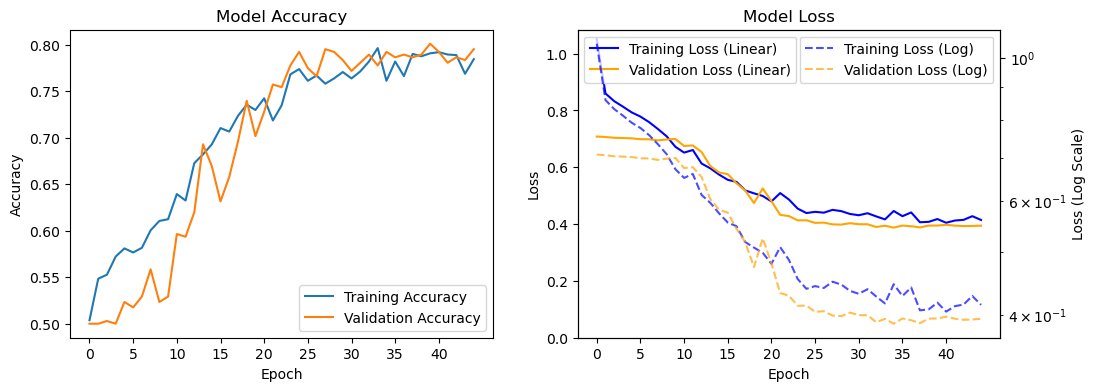

In [9]:
params = {'conv_filters': 16, 'kernel_size': 2, 'lstm_units': 42, 'dropout_conv': 0.3134450505425244, 'dropout_lstm': 0.3890925768513884, 'learning_rate': 0.0007768151561933436, 'kernel_regularizer_l1': 1.7674487638525016e-05, 'kernel_regularizer_l2': 0.0004885403530296337}

history, model = neural_net_fun.training_process(timesteps, n_classes, n_features, X_train, X_val, Y_train, Y_val, params, batch_size)
neural_net_fun.plot_learning_curves(history)

## Evaluate the model performance

11/11 [==============================] - 0s 883us/step
Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1-Score: 0.80


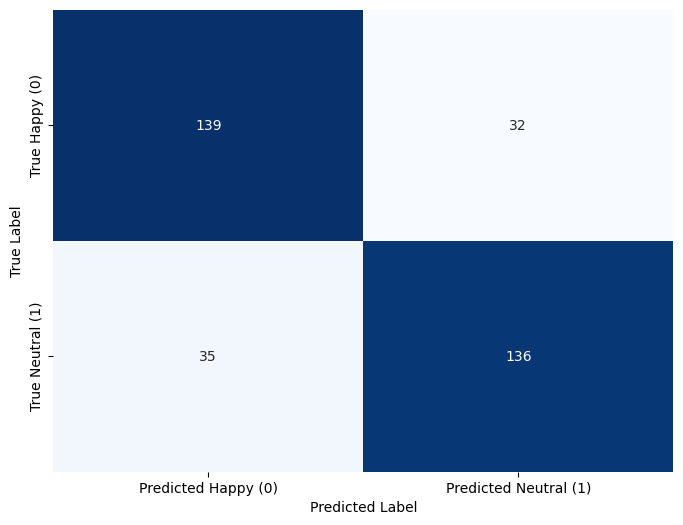

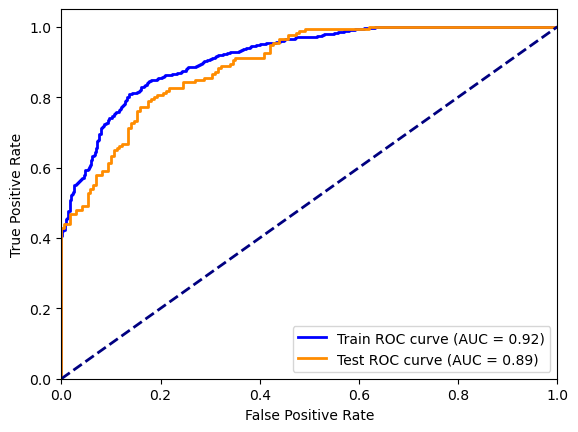

(0.804093567251462,
 0.8041871921182265,
 0.804093567251462,
 0.8040784917275875,
 array([[139,  32],
        [ 35, 136]]))

In [10]:
neural_net_fun.evaluate_model_performance(model,  X_train, Y_train, X_test, Y_test)

## Save the models

In [11]:
model.save('model.keras')